In [48]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [49]:
# data parameters
n_monto_carlo = 10 ** 5
n_assets = 7
risky_asset = ['TSLA', 'AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META']

In [62]:
# download the data
prices_df = pd.read_csv("LSTM.csv")
prices_df = prices_df['Date']
for i in risky_asset:
    prices_df[i] = pd.read_csv(f"Test_Prediction_{i}1.csv")
prices_df.set_index('Date', inplace=True)
print(f'read {prices_df.shape[0]} rows of data.')
N_DAYS = prices_df.shape[0]
#prices_df = prices_df.dropna()
prices_df

FileNotFoundError: [Errno 2] No such file or directory: 'Test_Prediction_TSLA1.csv'

In [51]:
# show the percentage returns

returns_df = prices_df
returns_df.head()

,Train_Prediction_AAPL,Test_Prediction_TSLA,Test_Prediction_MSFT,Test_Prediction_NVDAL,Test_Prediction_GOOGL,Train_Prediction_AMZN,Test_Prediction_META
Date,,,,,,,
3.059304,NaN,39.086227,NaN,30.790577,NaN,108.712578,NaN
3.193042,NaN,39.188896,NaN,30.630274,NaN,109.188553,NaN
2.843266,NaN,39.080826,NaN,30.573164,NaN,109.412552,NaN
2.521796,NaN,38.180641,NaN,29.335320,NaN,104.701454,NaN
2.354635,NaN,37.685329,NaN,29.290735,NaN,104.151367,NaN


In [52]:
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
avg_returns, cov_mat

(Train_Prediction_AAPL    656157.089891
 Test_Prediction_TSLA     114895.035928
 Test_Prediction_MSFT     256926.658938
 Test_Prediction_NVDAL    153386.476492
 Test_Prediction_GOOGL    299924.961097
 Train_Prediction_AMZN    358563.088530
 Test_Prediction_META     582589.590399
 dtype: float64,
                        Train_Prediction_AAPL  Test_Prediction_TSLA  \
 Train_Prediction_AAPL           1.036635e+08                   NaN   
 Test_Prediction_TSLA                     NaN         271572.150185   
 Test_Prediction_MSFT            6.937288e+06                   NaN   
 Test_Prediction_NVDAL                    NaN         746183.988262   
 Test_Prediction_GOOGL           4.248694e+06                   NaN   
 Train_Prediction_AMZN                    NaN         815099.327400   
 Test_Prediction_META            3.197631e+07                   NaN   
 
                        Test_Prediction_MSFT  Test_Prediction_NVDAL  \
 Train_Prediction_AAPL          6.937288e+06                  

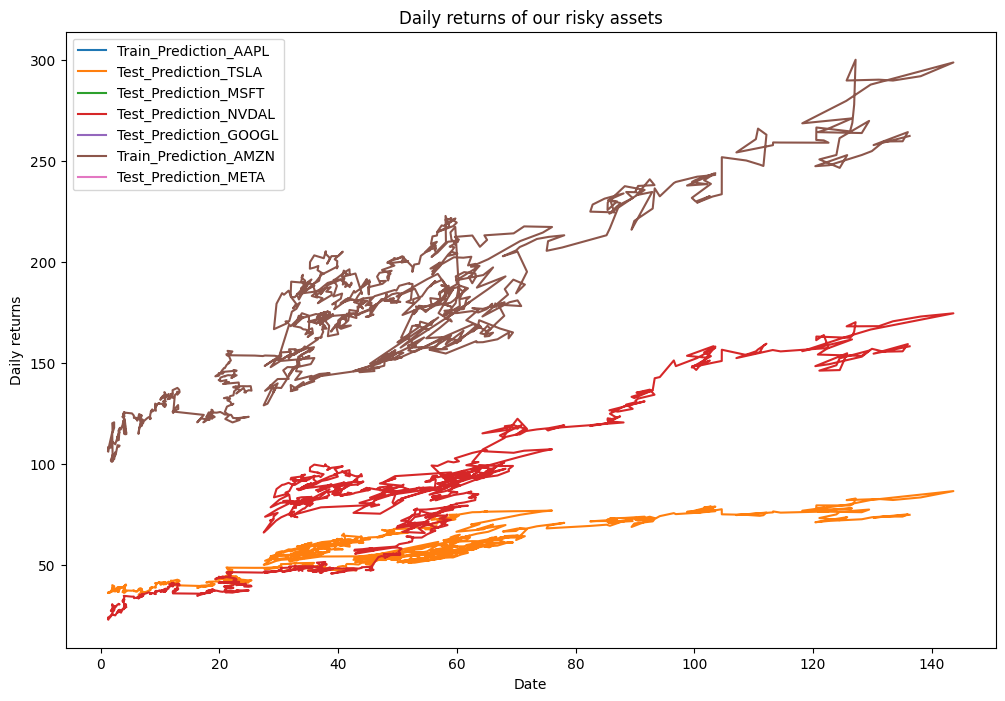

In [53]:
returns_df.plot(title='Daily returns of our risky assets')
plt.ylabel('Daily returns')
plt.show()

In [54]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [55]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [56]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [57]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

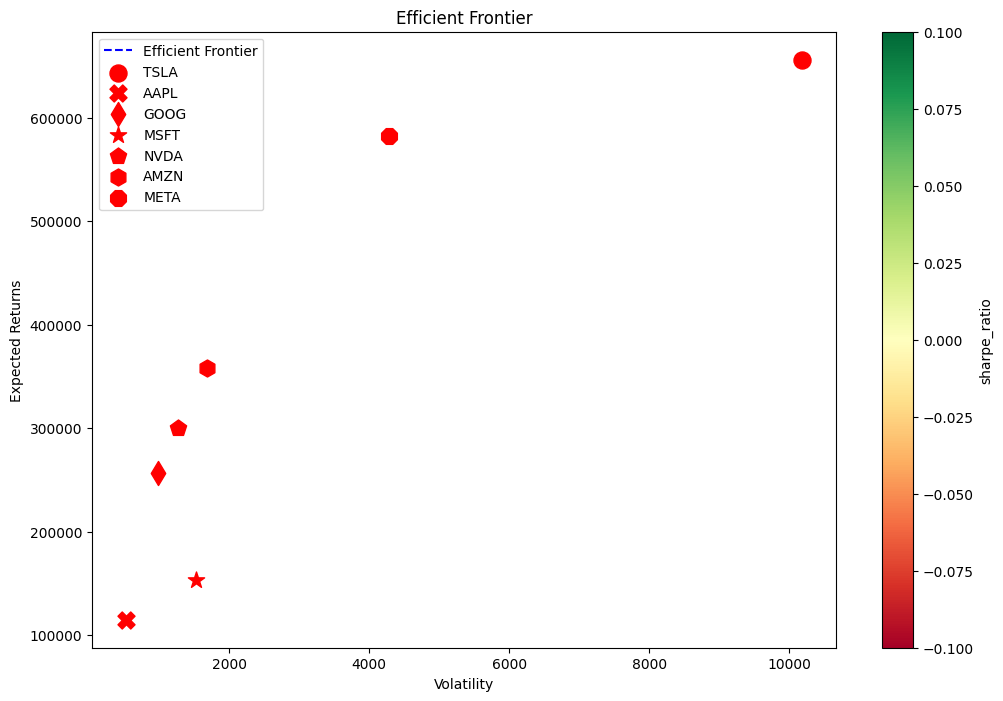

In [58]:
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

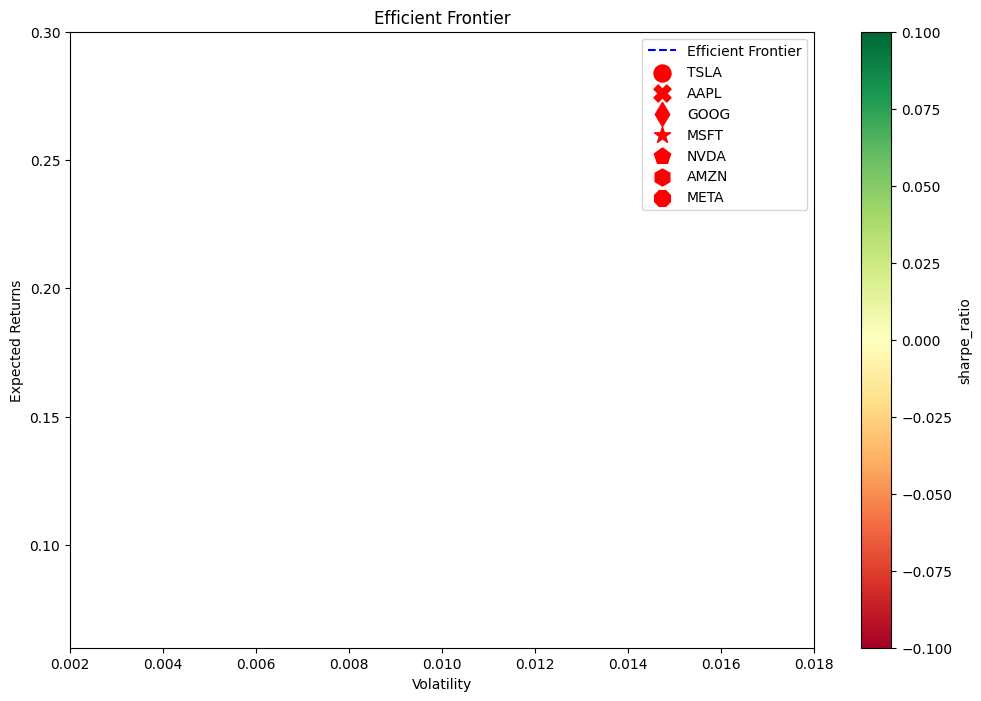

In [59]:
# a bigger figure
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax, s = 45)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier',\
       xlim = (0.002, 0.018), ylim = (0.06, 0.3))
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

In [60]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

KeyError: -1

In [ ]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 8.55% volatility: 0.23% sharpe_ratio: 3791.13% 
Weights:
TSLA: 0.87% AAPL: 42.84% GOOG: 17.38% MSFT: 10.30% NVDA: 4.51% AMZN: 21.28% META: 2.82% 

In [ ]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 8.55% volatility: 0.23% sharpe_ratio: 3791.13% 
Weights:
TSLA: 0.87% AAPL: 42.84% GOOG: 17.38% MSFT: 10.30% NVDA: 4.51% AMZN: 21.28% META: 2.82% 

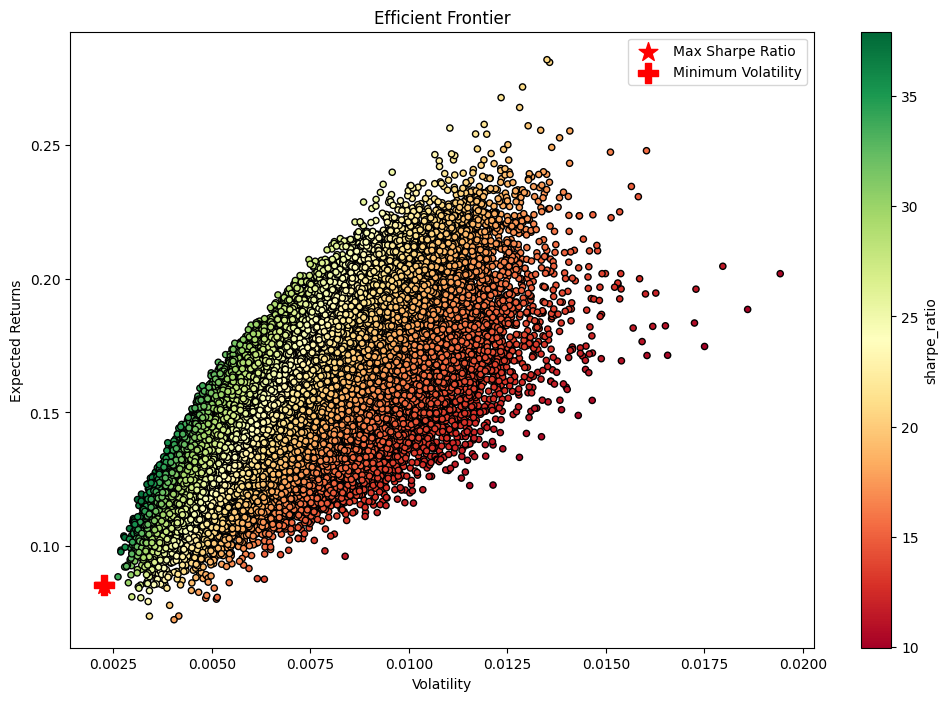

In [ ]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()